## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## 1-Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

In [1]:
import os
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline
#%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

# Callibrate camera
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)


NameError: name 'undistortImage' is not defined

---
## 2-Apply a distortion correction to raw images.

Text(0.5, 1.0, 'Undistorted Image')

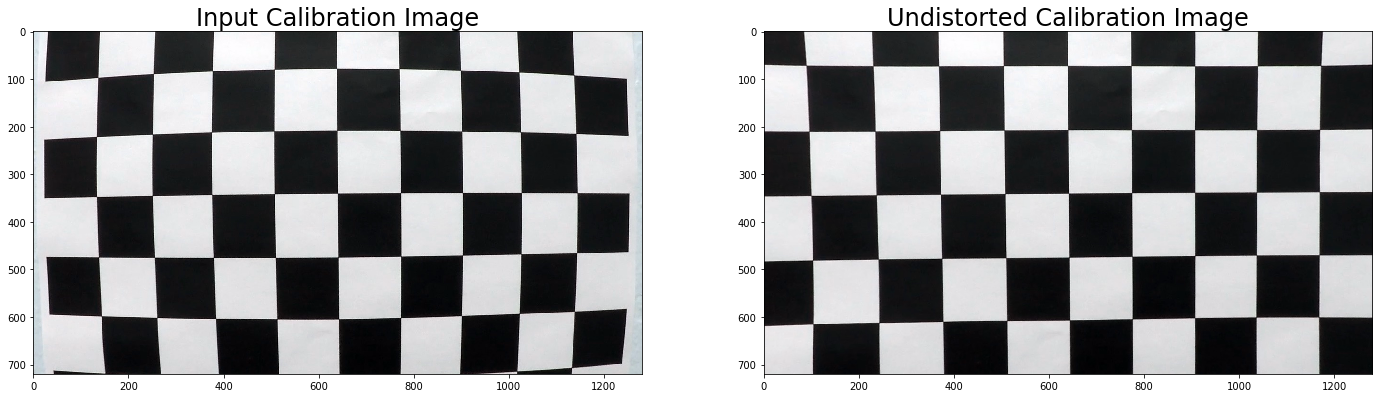

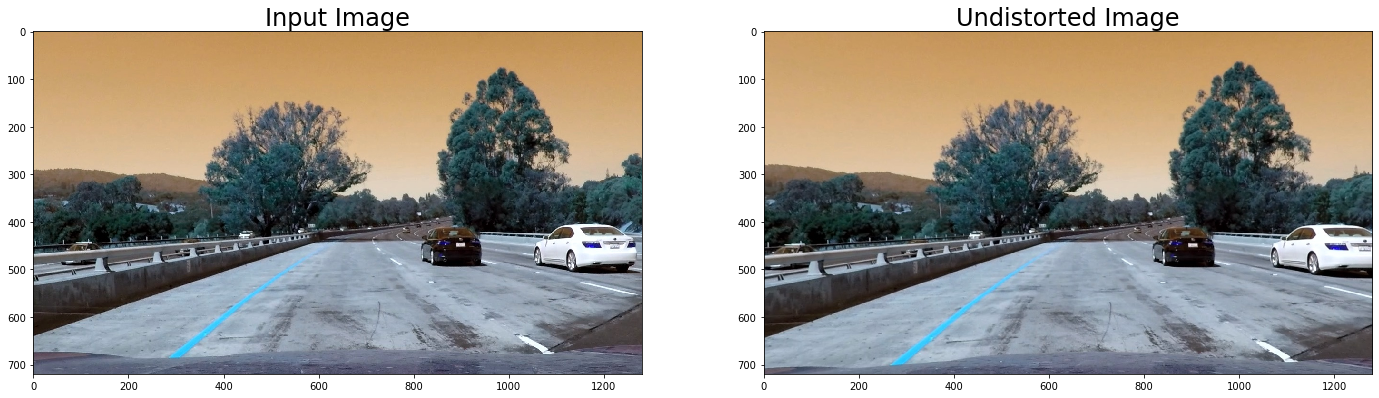

In [82]:
# Create a undistort image function
# Takes as input:
#  image: input image
#  objpoints: object points from camera calibration
#  imgpoints: image points from camera calibration
# Output: an undistorted image
def undistortImage(imgIn, objpoints, imgpoints):
    gray = cv2.cvtColor(imgIn,cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return cv2.undistort(imgIn, mtx, dist, None, mtx)

# Show the undistorted test image
imgTest = cv2.imread('camera_cal/calibration1.jpg')
imgUndist = undistortImage(imgTest, objpoints, imgpoints)
# Display the results
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax1.imshow(imgTest)
ax1.set_title('Input Calibration Image', fontsize=24)
ax2.imshow(imgUndist)
ax2.set_title('Undistorted Calibration Image', fontsize=24)

# Test the undistort function
imgTest = cv2.imread('test_images/test1.jpg')
imgUndist = undistortImage(imgTest, objpoints, imgpoints)
# imgTest = cv2.GaussianBlur(imgUndist, (5, 5), 0)

# Display the results
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax1.imshow(imgTest)
ax1.set_title('Input Image', fontsize=24)
ax2.imshow(imgUndist)
ax2.set_title('Undistorted Image', fontsize=24)

In [4]:
# Undistort all images in test_images directory and save the result into output_images directory.
basepath = "./test_images/"
for file in os.listdir(basepath):
    if os.path.isfile(os.path.join(basepath, file)):
        imgIn = cv2.imread(os.path.join('test_images', file))
        imgOut = undistortImage(imgIn, objpoints, imgpoints)
        outputFileName = './output_images/' + file.split('.')[0] + '.jpg'
        cv2.imwrite(outputFileName, imgOut)

---
## 3-Use color transforms, gradients, etc., to create a thresholded binary image.


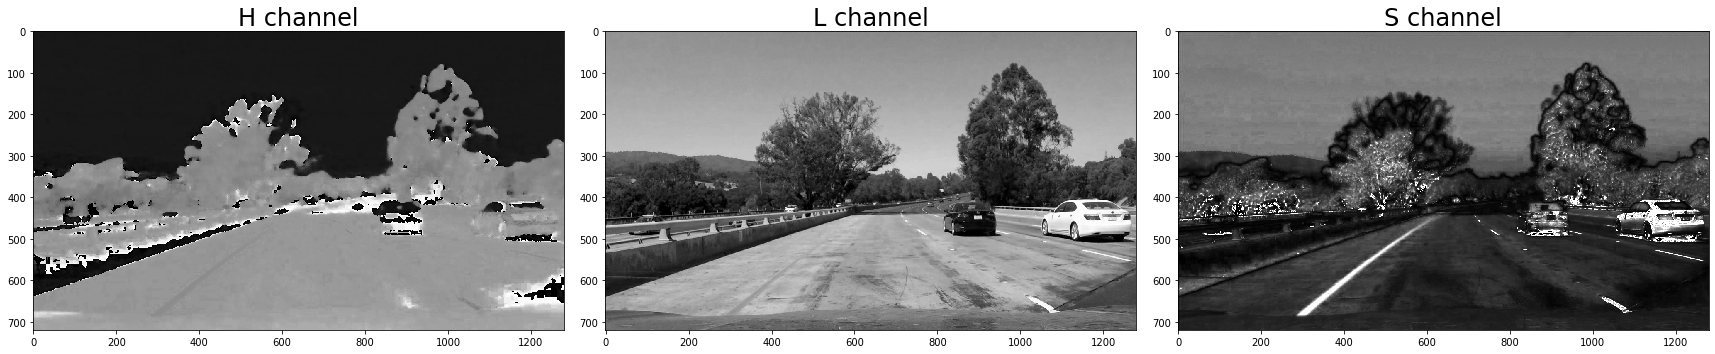

In [103]:
# 3.1: Color Transform
def RGB2HLS(imgIn):
    imgHLS = cv2.cvtColor(imgIn, cv2.COLOR_RGB2HLS)
    imgH = imgHLS[:,:,0]
    imgL = imgHLS[:,:,1]
    imgS = imgHLS[:,:,2]
    return imgH,imgL,imgS

# Extract test image channel
imgH, imgL, imgS = RGB2HLS(imgTest)

# Remove the noise 
kSize=1
imgH = cv2.GaussianBlur(imgH, (kSize, kSize), 0)
imgL = cv2.GaussianBlur(imgL, (kSize, kSize), 0)
imgS = cv2.GaussianBlur(imgS, (kSize, kSize), 0)

# Display the results
f,(ax1,ax2,ax3) = plt.subplots(1, 3, figsize = (24,9))
f.tight_layout(pad=3)
f.tight_layout()
ax1.set_title('H channel', fontsize=24)
ax1.imshow(imgH, cmap= 'gray')
ax2.set_title('L channel', fontsize=24)
ax2.imshow(imgL, cmap= 'gray')
ax3.set_title('S channel', fontsize=24)
ax3.imshow(imgS, cmap='gray')

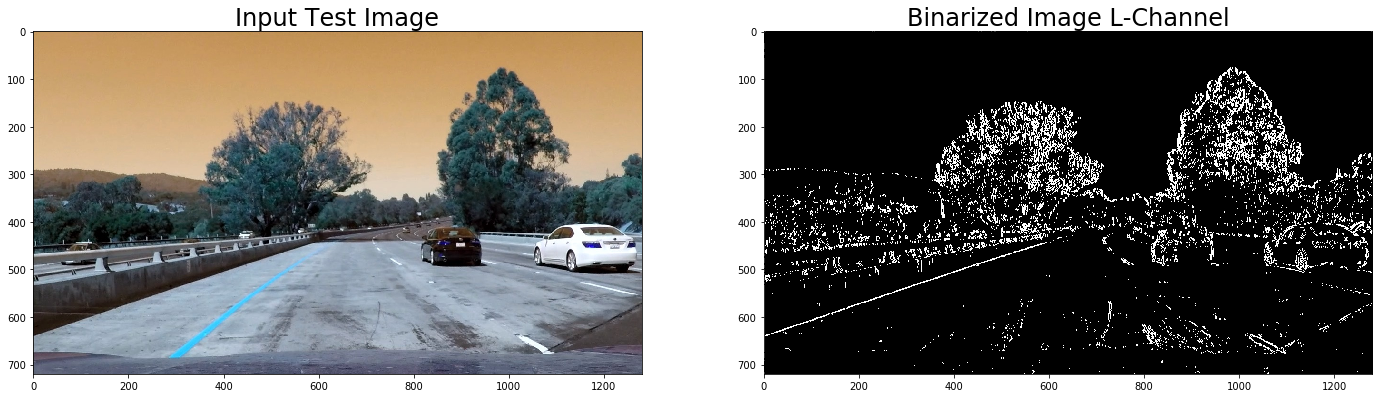

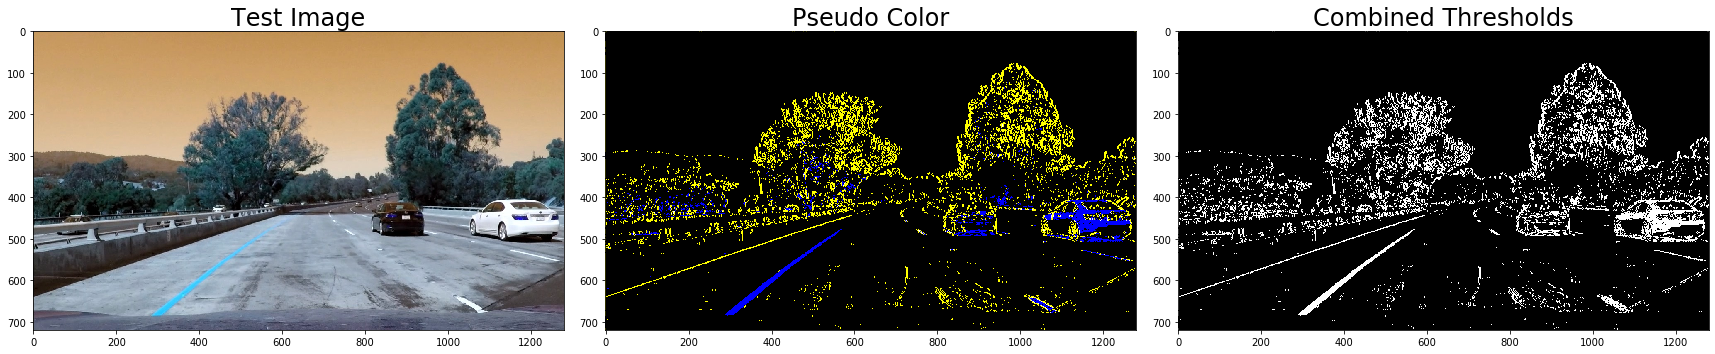

In [144]:
# 3.2: Create a binary image by applying Sobel gradient operator followed by thresholding
def binarizeImage(imgIn, orient = 'x', thresh=[0,255], kSize=5):
    if orient == 'x':
        imgSobelX = cv2.Sobel(imgIn, cv2.CV_64F, 1, 0, ksize=kSize)
        imgAbs = np.absolute(imgSobelX)
    elif orient == 'y':
        imgSobelY = cv2.Sobel(imgIn, cv2.CV_64F, 0, 1, ksize=kSize)
        imgAbs = np.absolute(imgSobelY)
    elif orient == 'mag':
        imgSobelX = cv2.Sobel(imgIn, cv2.CV_64F, 1, 0, ksize=kSize)
        imgSobelY = cv2.Sobel(imgIn, cv2.CV_64F, 0, 1, ksize=kSize)
        imgSobelMag = np.sqrt(imgSobelX**2 + imgSobelY**2)
        imgAbs = np.absolute(imgSobelMag)
    elif orient == 'dir':
        imgSobelX = cv2.Sobel(imgIn, cv2.CV_64F, 1, 0, ksize=kSize)
        imgSobelY = cv2.Sobel(imgIn, cv2.CV_64F, 0, 1, ksize=kSize)
        imgSobelDir = np.arctan2(np.absolute(imgSobelX), np.absolute(imgSobelY))
        imgAbs = np.absolute(imgSobelDir)
    else: # such as 'col'
        imgAbs = np.absolute(imgIn)
        
    imgScaled = np.uint8(255. * imgAbs / np.max(imgAbs))
    imgBinary = np.zeros_like(imgScaled)
    imgBinary[(imgScaled >= thresh[0]) & (imgScaled <= thresh[1])] = 1 # Thresholding
    return imgBinary

# Test the binarizeImage function on imgL
imgBinary = binarizeImage(imgL, orient='x', thresh=[20,100], kSize=5)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax1.imshow(imgTest)
ax1.set_title('Input Test Image', fontsize=24)
ax2.imshow(imgBinary, cmap='gray')
ax2.set_title('Binarized Image L-Channel', fontsize=24)

# Combine multiple thresholds
def thresholdImage(imgH, imgL, imgS, b_thresh=[0,255], c_thresh=[0,255], kSize=5):
    # Apply Soble threshold
    imgBinaryX = binarizeImage(imgL, orient='x', thresh=b_thresh, kSize=kSize)
    #imgBinaryY = binarizeImage(imgL, orient='y', thresh=b_thresh, kSize=kSize)
    #imgBinaryMag = binarizeImage(imgL, orient='mag', thresh=b_thresh, kSize=kSize)
    #imgBinaryDir = binarizeImage(imgL, orient='dir', thresh=b_thresh, kSize=kSize)
    imgBinaryCol = binarizeImage(imgS, orient='col', thresh=c_thresh, kSize=kSize) # Threshold color channel
    imgBinary = imgBinaryX
    
    imgCombined = np.zeros_like(imgBinary)
    imgCombined[(imgBinary == 1) | (imgBinaryCol == 1)] = 1    
    
    # Create a pseudo color imagehe lowest value to 0 and the highest to 255. 
    imgColorBinary = np.dstack(((imgBinary*255, imgBinary*255, imgBinaryCol*255)))

    return imgColorBinary, imgCombined

# Test the thresholdImage function on imgL
imgColorBinary, imgCombined = thresholdImage(imgH, imgL, imgS, b_thresh=[20,100], c_thresh=[170,255], kSize=5) #10, 160
f,(ax1,ax2,ax3) = plt.subplots(1, 3, figsize = (24,9))
f.tight_layout()
ax1.set_title('Test Image', fontsize=24)
ax1.imshow(imgTest)
ax2.set_title('Pseudo Color', fontsize=24)
ax2.imshow(imgColorBinary)
ax3.set_title('Combined Thresholds', fontsize=24)
ax3.imshow(imgCombined, cmap='gray')

---
## 4-Apply a perspective transform to rectify binary image ("birds-eye view").


---
## 5-Detect lane pixels and fit to find the lane boundary.


---
## 6-Determine the curvature of the lane and vehicle position with respect to center.


---
## 7-Warp the detected lane boundaries back onto the original image.


---
## 8-Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
